<h1><center>Evaluating the Efficacy of Supervised Machine Learning Models in Diagnosing Cervical Cancer</center></h1>

## 1. Introduction
&emsp; Cervical cancer was once one of the most common causes of cancer related mortality in women.  The use of preventative screening (pap smears, and more recently HPV screening) has largely decreased the mortality and even the incidence of cervical cancer by helping to identify precancerous growths (Cervical Cancer Statistics, 2022).  It remains important, however, to obtain a rapid diagnosis any time that cancer is present.  The 5-year survival rate among cervical cancer patients drops from 92% if their cancer is localized, to 18% if the cancer has metastasized to a distant site (Cervical Cancer Survival Rates, 2022).  Additionally, the hospital system in the United States is currently undergoing a reduction in capacity due to the ongoing COVID-19 pandemic.  Automated diagnostic tools can assist medical professionals, potentially decreasing diagnostic time, and increasing detection rates.
<br>
&emsp; In this study, we will attempt to use supervised machine learning classification to predict whether a patient has been diagnosed with cervical cancer.  We will use data from a study similar to this to see if we can achieve a similar result.  The data were collected at a hospital in Caracas, Venezuela from 858 patients (Fernandes et al., 2017).  It contains 35 attributes of surveyed medical history, as well as medical diagnoses.  Ten of them are numerical values, the other 25 are Boolean.  We will evaluate a naive version of eight different algorithms before choosing three to optimize using a Bayesian search of the hyperparameters.

In [1]:
import pandas as pd
import numpy as np
import warnings
from tabulate import tabulate
from prettytable import PrettyTable, ALL
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn.preprocessing as preprocessing
from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import (fbeta_score, make_scorer, confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_curve,
                             PrecisionRecallDisplay)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [2]:
r_state = 42

## 2. Data Preprocessing
### 2.1 Import
&emsp; The data that we are using is hosted by the public University of California Irvine Machine Learning Repository.  We are importing it live from the repository, but in case the data becomes unavailable we have included a static version, current as of the time of writing.  The data were collected on March 3rd, 2017, and have not been updated since then.  Since the dataset was collected as part of a prior study, we don't expect the data to change significantly.

In [3]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv')

In [4]:
# To import the static data, use the alternate code commented out below
# df = pd.read_csv('./data/risk_factors_cervical_cancer.csv')

In [5]:
df

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34,3.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
854,32,2.0,19.0,1.0,0.0,0.0,0.0,1.0,8.0,0.0,...,?,?,0,0,0,0,0,0,0,0
855,25,2.0,17.0,0.0,0.0,0.0,0.0,1.0,0.08,0.0,...,?,?,0,0,0,0,0,0,1,0
856,33,2.0,24.0,2.0,0.0,0.0,0.0,1.0,0.08,0.0,...,?,?,0,0,0,0,0,0,0,0


## 2.2 Data Cleaning
&emsp; It is important to make sure that the data are complete, and clean.  Machine learning algorithms take attributes of the data literally, so it is important to make sure that the data is in a state that will enable the algorithm to learn from the features we want it to.

### 2.2.1 Replace all '?' with np.nan
&emsp; The metadata on the UCI Machine Learning Repository mentions that there are missing values, and that some patients decided not to answer some of the questions due to privacy concerns. We will look at these values first, because the missing data could influence which columns and rows are relevant.  Since most of the data features are Boolean, or integers within a constrained range, we can check all of the unique values in each category manually.  It appears that most of the 'NA' values in this data are represented by a question mark.  It is important to replace them with a value that is more easily recognized by the pandas library.

In [6]:
unique = PrettyTable(['Column', 'Unique Values'])
for i in df.columns:
    unique.add_row([i, df[i].unique()])
unique.hrules = ALL
print(unique.get_string())

+------------------------------------+----------------------------------------------------------------------------+
|               Column               |                               Unique Values                                |
+------------------------------------+----------------------------------------------------------------------------+
|                Age                 |  [18 15 34 52 46 42 51 26 45 44 27 43 40 41 39 37 38 36 35 33 31 32 30 23  |
|                                    |        28 29 20 25 21 24 22 48 19 17 16 14 59 79 84 47 13 70 50 49]        |
+------------------------------------+----------------------------------------------------------------------------+
|     Number of sexual partners      | ['4.0' '1.0' '5.0' '3.0' '2.0' '6.0' '?' '7.0' '15.0' '8.0' '10.0' '28.0'  |
|                                    |                                   '9.0']                                   |
+------------------------------------+----------------------------------

In [7]:
#replace '?' with np.nan
df = df.replace('?', np.nan)

### 2.2.2 Quantifying nan values
&emsp; Now that the missing data have been identified and labelled appropriately, we need to decide how we will deal with it.  The first thing we need to do is understand the distribution and quantity of missing values.  We can see that there are a number of columns that contain missing values.  We will divide them into a few categories based on the percentage of missing values.

| 0% | 0-5% | 5-10% | 10-15% | 15-90% | 90-100% |
|----|------|-------|--------|--------|---------|
| 10 | 5    | 1     | 18     | 0      | 2       |

&emsp; Obviously, the columns with 0% missing values need no further processing.  Next, we look at the values that are in a range where imputation could be appropriate.  Typical cutoffs for imputation are below 5% and below 10%.  Because only one of the columns is in the 5-10% bin, we will retain the columns, and plan to resolve the rows with a K-nearest neighbor strategy.
The 10-15% bin is an interesting one; the plurality of columns fall into this category.  Interestingly, 14 out of 18 columns have the exact same number of null values, 105.  Upon closer inspection, we can see that the lines that contain 'nan' in the 'STDs' column also contain a high percentage of nan values.  Over 90% of these rows are missing half of the data.  We suspect that these rows represent the data of the patients mentioned in the metadata that declined to answer the survey for privacy reasons.  If the rows were removed, the above table would look like this:

| 0% | 0-5% | 5-10% | 10-15% | 15-90% | 90-100% |
|----|------|-------|--------|--------|---------|
| 24 | 9    | 1     | 0      | 0      | 2       |

&emsp; Removing those 105 rows results in a much more desirable breakdown of missing values.  We can now fairly easily decide that the ten features with less than 10% missing values will be imputed.  The two columns with over 90% missing values are too sparse to try to salvage, so will drop them.


In [8]:
def join_sums_to_df(sum1, sum2, sum1_name, sum2_name):
    df_sum = sum1.to_frame(sum1_name)
    df_sum2 = sum2.to_frame(sum2_name).join(df_sum)
    return df_sum2

In [9]:
df_nulls = join_sums_to_df(round(df.isnull().sum()*100/len(df), 1),
                           df.isnull().sum(),
                           'Null Percent',
                           'Null Count')
df_nulls['Null Percent'] = df_nulls['Null Percent'].astype(str) + ' %'
print(df_nulls)

                                    Null Count Null Percent
Age                                          0        0.0 %
Number of sexual partners                   26        3.0 %
First sexual intercourse                     7        0.8 %
Num of pregnancies                          56        6.5 %
Smokes                                      13        1.5 %
Smokes (years)                              13        1.5 %
Smokes (packs/year)                         13        1.5 %
Hormonal Contraceptives                    108       12.6 %
Hormonal Contraceptives (years)            108       12.6 %
IUD                                        117       13.6 %
IUD (years)                                117       13.6 %
STDs                                       105       12.2 %
STDs (number)                              105       12.2 %
STDs:condylomatosis                        105       12.2 %
STDs:cervical condylomatosis               105       12.2 %
STDs:vaginal condylomatosis             

In [10]:
df_nulls_std = join_sums_to_df(round(df[df['STDs'].isnull()].isnull().sum()*100/len(df[df['STDs'].isnull()]), 1),
                               df[df['STDs'].isnull()].isnull().sum(),
                               'Null Percent|STD=True',
                               'Null Count|STD=True')
df_nulls_std['Null Percent|STD=True'] = df_nulls_std['Null Percent|STD=True'].astype(str) + ' %'
print(df_nulls_std)

                                    Null Count|STD=True Null Percent|STD=True
Age                                                   0                 0.0 %
Number of sexual partners                            12                11.4 %
First sexual intercourse                              1                 1.0 %
Num of pregnancies                                    9                 8.6 %
Smokes                                                3                 2.9 %
Smokes (years)                                        3                 2.9 %
Smokes (packs/year)                                   3                 2.9 %
Hormonal Contraceptives                              95                90.5 %
Hormonal Contraceptives (years)                      95                90.5 %
IUD                                                 101                96.2 %
IUD (years)                                         101                96.2 %
STDs                                                105         

In [11]:
# df[df['STDs'].isnull() != True].isnull().sum()
df_nulls_std = join_sums_to_df(round(df[df['STDs'].isnull() != True].isnull().sum()*100/len(df[df['STDs'].isnull() != True]), 1),
                               df[df['STDs'].isnull() != True].isnull().sum(),
                               'NullPercent|STD=False',
                               'NullCount|STD=False')
df_nulls_std['NullPercent|STD=False'] = df_nulls_std['NullPercent|STD=False'].astype(str) + ' %'
print(df_nulls_std)

                                    NullCount|STD=False NullPercent|STD=False
Age                                                   0                 0.0 %
Number of sexual partners                            14                 1.9 %
First sexual intercourse                              6                 0.8 %
Num of pregnancies                                   47                 6.2 %
Smokes                                               10                 1.3 %
Smokes (years)                                       10                 1.3 %
Smokes (packs/year)                                  10                 1.3 %
Hormonal Contraceptives                              13                 1.7 %
Hormonal Contraceptives (years)                      13                 1.7 %
IUD                                                  16                 2.1 %
IUD (years)                                          16                 2.1 %
STDs                                                  0         

In [12]:
df = df.drop(df[df.STDs.isnull()].index)
df = df.drop(df[['STDs: Time since first diagnosis','STDs: Time since last diagnosis']], axis = 1)
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


### 2.2.3 Fixing Data Type Labels
&emsp; If we look at the data types of our dataframe's columns, we can see that all of the columns are classified as integer or object.  Having seen the unique values, we know that a number of columns are Boolean, and that certain columns, like "Smokes (years)", should be numerical.  It is important to label the data correctly, so that the algorithm can correctly interpret the data.  For example, let's consider a K-nearest neighbor model looking at "Smokes (years)" with the values (1, 2, 25).  If the data label is "Integer", the KNN algorithm would recognize the distance between 1 and 2 as 1, and the distance between 2 and 25 as 23.  If the data label was "object" the algorithm would see the three values as distinct, non-ordinal, categorical values, and the distance between all values would just be 1.
<br>
&emsp; The metadata contains a list of data types, however we noticed that it only contains the types "Int" and "Bool".  Looking at the unique values, we can see that there are "Float" values present.  We will use an automated approach to assignment, as we don't trust the metadata list.

In [13]:
print(df.dtypes)

Age                                    int64
Number of sexual partners             object
First sexual intercourse              object
Num of pregnancies                    object
Smokes                                object
Smokes (years)                        object
Smokes (packs/year)                   object
Hormonal Contraceptives               object
Hormonal Contraceptives (years)       object
IUD                                   object
IUD (years)                           object
STDs                                  object
STDs (number)                         object
STDs:condylomatosis                   object
STDs:cervical condylomatosis          object
STDs:vaginal condylomatosis           object
STDs:vulvo-perineal condylomatosis    object
STDs:syphilis                         object
STDs:pelvic inflammatory disease      object
STDs:genital herpes                   object
STDs:molluscum contagiosum            object
STDs:AIDS                             object
STDs:HIV  

In [14]:
obj_cols = df.loc[:, df.dtypes == object].columns
df[obj_cols] = df[obj_cols].apply(pd.to_numeric, errors = 'coerce', axis=1)

for i, name in enumerate(df):
    if all((val == 0 or val == 1 or np.isnan(val) for val in df[name])):
        df[name] = df[name].astype('bool')

typeDict = {}
for i, name in enumerate(df):
    typeDict[name] = df[name].dtypes

## 2.3 Data Imputation
&emsp; Now that we have cleaned up our data, we are ready to fill in the missing values that we decided to keep.  For this task, we are going to use K-nearest neighbor imputation.  We have selected this algorithm because the model is easy to train (requires no fitting), it is easy to implement, and is flexible if new data are added.  It would not work well if the dimensionality of the data were higher, or if this data gained many more samples.
&emsp; Because KNN models judge the distance between individual values, it requires feature normalization.  If we failed to normalize, KNN would give different weighting to features that span different ranges, which is not what we want.  We would like the imputation to treat each feature equally.  We will utilize a linear min-max scaling algorithm which sets the lowest and highest values to 0 and 1 respectively, then places the rest of the points between, maintaining the original distribution.

In [15]:
scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,0.070423,0.111111,0.227273,0.090909,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.028169,0.000000,0.181818,0.090909,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.295775,0.000000,NaN,0.090909,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.549296,0.148148,0.272727,0.363636,1.0,1.0,1.0,1.0,0.136364,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.464789,0.074074,0.500000,0.363636,0.0,0.0,0.0,1.0,0.681818,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
imputer = KNNImputer(missing_values=np.nan)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [17]:
for i, name in enumerate(df):
    if all((val == 0 or val == 1 or np.isnan(val) for val in df[name])):
        df[name] = df[name].astype('bool')

# 3 Exploratory Data Analysis
&emsp; Now we can have a look at the properties of the data.  It is valuable to use visualization and reshaping of the data to better understand the problem at hand.  Additionally, certain properties of the data can influence the choice of predictive model.
## 3.1 Imbalance
&emsp; In this case, we can see that one of the most notable features of the data is that it is highly imbalanced with respect to the dependent variable ("Dx").  This can pose a problem for machine learning algorithms, as many of them were designed to operate effectively with balanced data.  Machine learning models trained on imbalanced data have a tendency to under-represent the minority class.  We will have to come up with a strategy to minimize this effect.

<AxesSubplot:xlabel='Dx', ylabel='count'>

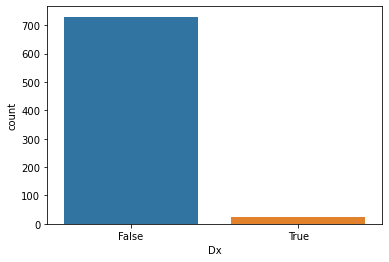

In [18]:
sns.countplot(x=df['Dx'])

In [19]:
dx_perc = str(round(df['Dx'].sum()/len(df['Dx']) * 100, 2))
print("Ratio of patients diagnosed with cervical cancer: \033[1m{}\033[0m%".format(dx_perc))

Ratio of patients diagnosed with cervical cancer: 3.05%


## 3.2 Distributions
&emsp; Most numeric values appear to be roughly normally distributed, with the exception of any values which measure time in year.  These columns appear to have an exponential distribution, which should be fine.  The numeric data does not yield useful insights when the distribution of the positive and negative data are compared.

<AxesSubplot:>

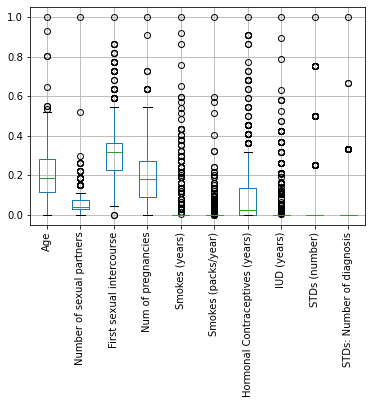

In [20]:
df.select_dtypes(exclude=bool).boxplot(rot=90)

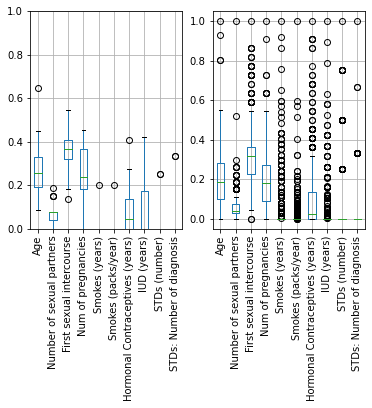

In [21]:
plt.subplot(1,2,1)
boxplot_cancer = df.loc[df['Dx'] == 1].select_dtypes(exclude=bool).boxplot(rot=90, return_type='axes')
boxplot_cancer.set_ylim(0,1)

plt.subplot(1,2,2)
boxplot_no_cancer = df.loc[df['Dx'] != 1].select_dtypes(exclude=bool).boxplot(rot=90)

plt.show()

## 3.3 Discarding Valueless Features
&emsp; Not all columns hold meaningful data.  In many cases, the decision to drop variables can come from domain specific knowledge, a known methodology flaw, or a flaw in the data itself.  In this case, we have limited domain knowledge, and have not eliminated any attributes based on this criteria.  We have, however, noticed that 2 Boolean columns have only false values, "STDs:cervical condylomatosis" and "STDs:AIDS".  Because there cannot be differentiation between positive and negative values in these fields, we have chosen to eliminate them.  We will, however, note that "STDs:HIV" is still in the data, and that none of those patients had AIDS.

In [22]:
for i in df.columns:
    if len(df[i].unique()) == 0 or len(df[i].unique()) ==1:
        print(i, df[i].unique())
        df = df.drop(labels=i, axis=1)

STDs:cervical condylomatosis [False]
STDs:AIDS [False]


## 3.4 Linear Correlation Analysis
&emsp; Plotting the data correlation values pairwise, we can see some clear connections.  There are a few that we can immediately speculate on.  For example, age and number of pregnancies clearly have a relationship.  It makes sense that an older person will have, on average, more children than a younger person; especially considering that the age of people in the data set with a reported pregnancy ranges from 14 to 84.  Additionally, it would appear that:
- People who smoke longer tend to smoke more frequently
- People with at least one STD tend to have multiple
- The diagnostic tests "Hinselmann", "Schiller", "Citology", and "Biopsy" seem to be positively correlated with eachother, but only weakly with "Dx", our dependant variable
- "Dx" is strongly correlated with a previous diagnosis of cancer, a diagnosis of CIN (precancerous cells, likely detected by Pap smear), or a diagnosis of HPV (genital warts).

&emsp; It is interesting that the diagnostic tests only appear weakly correlated with a diagnosis of cervical cancer.  As these tests are widely used by the medical community, and have presumably undergone extensive scientific review regarding efficacy, it could be valuable to understand these data better.
<br>
&emsp; When viewing the non-Boolean features in a scatter pairplot, we can corroborate that linear correlations appear to be shaky at best.  The clustering, however, looks fairly promising.  We should be able to distinguish between our positive and negative data accurately, as long as we select the right classifier models.

<AxesSubplot:>

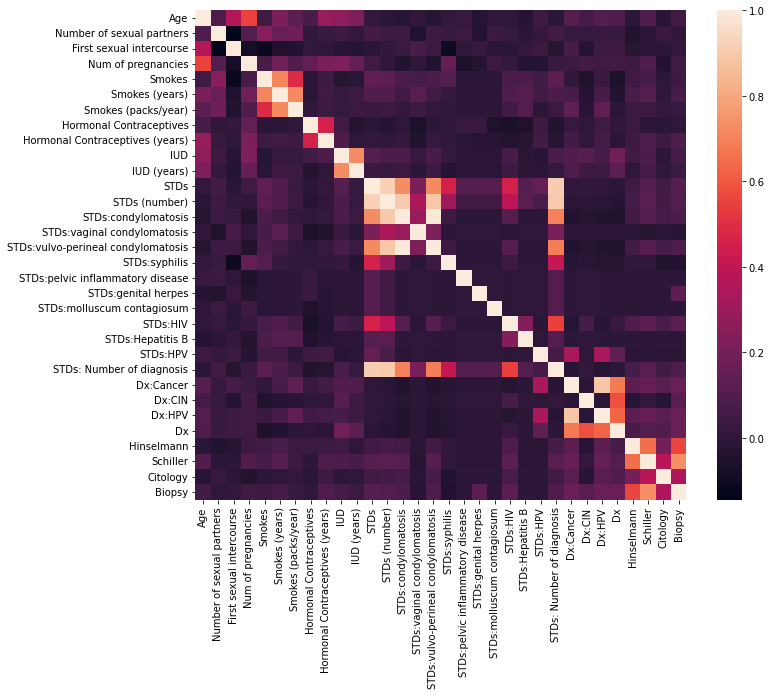

In [23]:
plt.subplots(figsize=(11,9))
sns.heatmap(df.corr())

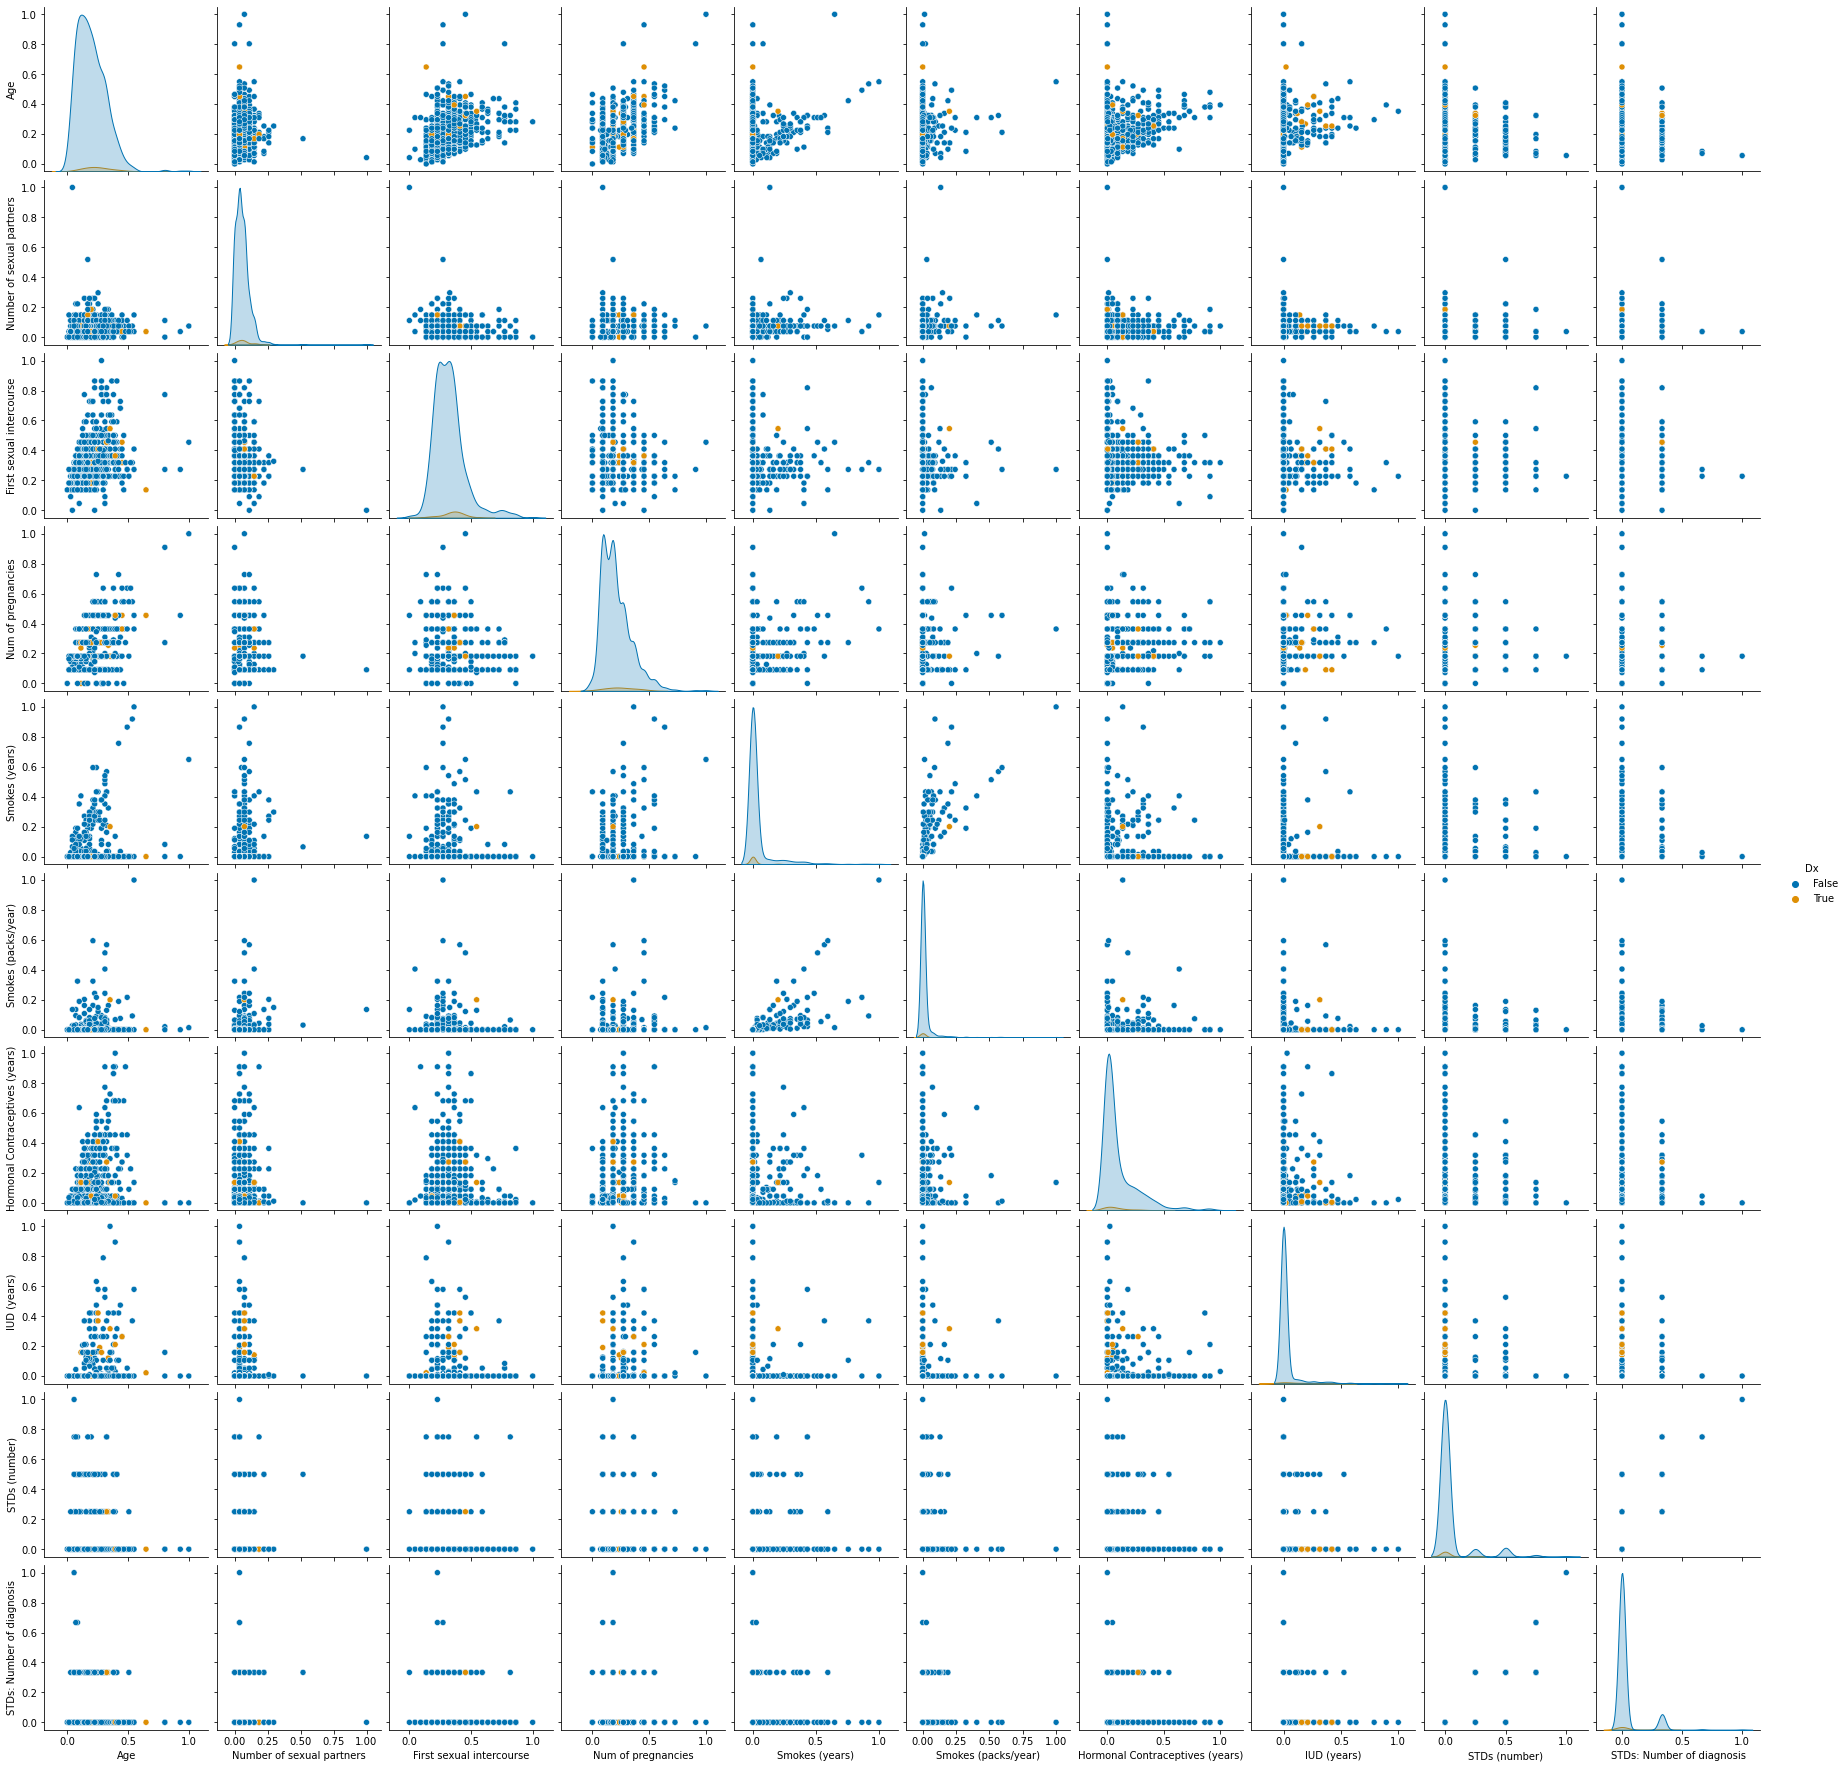

In [24]:
df2 = df.select_dtypes(exclude=bool).join(df.Dx)
sns.pairplot(data=df2, diag_kind = "kde", hue='Dx', palette='colorblind')

# 4. Data Modelling
&emsp;It is very important to select the correct predictive model for your data.  Models have varying strengths and weaknesses, and knowledge of this should inform our decision.  Generally speaking, our methodology will be to:
1. Determine a strategy to mitigate the weaknesses in our data
2. Pick a baseline naive classification algorithm appropriate for our data to benchmark our future models against
3. Select three appropriate supervised classification algorithms that leverage the strengths of our data, and prove that they can be performant
4. Optimize the selected model's hyperparameters using a Bayesian search

## 4.1 Mitigating Data Imbalance
&emsp; In our exploration of the data, the biggest hurdle we have identified is the imbalance in the dependent variable.  That is to say, very few people in our dataset (3.05%) were actually diagnosed with cervical cancer.  This poses a problem.  As an example, let's example the simplest predictive algorithm we can think of: simply predicting that nobody has cervical cancer.  If we used this model, we would obtain an accuracy of 96.95%.  On the surface that could seem like a good model until we realize that every error in that algorithm is a patient with cervical cancer that was classified as not having cancer.  This is obviously a much different situation than if we had accurately predicted 100% of the positive class and had some false positives.  Machine learning algorithms are typically optimized for balanced data and have a tendency to behave as described above when presented with imbalanced data.  There are a few techniques we could use to mitigate this effect.

### 4.1.1 Choosing an appropriate evaluation metric
&emsp; As discussed above, some evaluation metrics like accuracy may be inappropriate for our application.  Let's have a look at a few metrics and methods.
<br>
<br>
<dl>
    <dt>Confusion Matrix</dt>
    <dd>&emsp;The confusion matrix is going to be our "gold standard" of manual evaluation.  A confusion matrix will show us numerically how many positive and negative samples were correctly classified, and how many were misclassified; see the figure below (Srivastava, 2020).  This is very useful for a subjective analysis.  In order to use this information, we need to condense it into a "score", or a single value that can be used to compare two models.  In this case, we are particularly interested in the <strong>recall</strong> (named Sensitivity on the diagram), defined as the number of correctly classified positives divided by the true number of positives.  A missed detection is much more important to us than a false positive.</dd>
    <img src="https://www.analyticsvidhya.com/blog/wp-content/uploads/2015/01/Confusion_matrix.png">
    <dd></dd>
    <dt>F-score</dt>
    <dd>&emsp;Although we are interested in the recall, we cannot use it as an optimization target for the same reason we cannot use accuracy.  If we predict that every patient has cancer, we can be certain that we have 100% recall, but the model holds no value because it provides no separation of the two classes. One adjustable scoring metric that utilizes recall is called the <strong>F score</strong>.  F-score has one adjustable parameter: $\beta$.  F-scores are often named for their value of $\beta$, such as "F1 score" when $\beta=1$.  As the value of $\beta$ changes, the balance between recall and precision changes.  An F1 score corresponds to the harmonic mean between precision and recall, and higher values of $\beta$ give <strong>recall</strong> more influence on the score.  We have chosen to use the <strong>F2 score</strong> for model optimization and evaluation. $$F_\beta =(1+\beta ^2)\cdot \frac{\mathrm{precision\cdot recall}}{(\beta ^2\cdot precision)+recall}$$</dd>
</dl>

### 4.1.2 Resampling
&emsp;Another technique that is widely used to mitigate data imbalance is <strong>resampling</strong>.  Resampling is characterized as any technique that either generates new data, or removes existing data from your dataset.  There are many resampling strategies that generally fall into two categories, under-sampling and over-sampling.
<dl>
    <dt>Under-sampling</dt>
    <dd>&emsp;The result of under-sampling is a reduction in the volume of samples in the majority class.  There are a few common ways to select the samples to be removed, such as:</dd>
    <dd>&emsp;Random - samples are removed from the majority class at random</dd>
    <dd>&emsp;Near miss - majority samples that are close to minority samples are removed to sharpen the boundry between them</dd>
    <dd>&emsp;Condensed nearest neighbor - seek a "minimal consistent subset", or a subset of the data that performs the same as the whole data</dd>
    <dt>Over-sampling</dt>
    <dd>&emsp;Random - minority samples are selected randomly <strong>with replacement</strong> until the desired ratios are reached</dd>
    <dd>&emsp;Synthetic Minority (SMOTE) - KNNs are computed for a random minority sample.  New samples are synthesized from averages of these samples</dd>
    <dt>Disadvantages</dt>
    <dd>&emsp;Although resampling can be a powerful tool, it does have some drawbacks.  Too much oversampling can cause <strong>overfishing</strong>, where features of the minority class are too inflated, and the model becomes overfit to the majority data.  All undersampling results in the destruction of data from the majority class, and too much reduction in the usable data weakens your model.  In many cases under and oversampling are used in conjunction to gain the benefits of both while mitigating the negative effects.  <strong>We will not be resampling</strong> our data.  The imbalance is so large that we have concerns about a resampled input not being representative of the greater population.</dd>
</dl>

### 4.1.3 Choosing appropriate modeling algorithms
&emsp;There are a few algorithms that notably perform better on imbalanced datasets.  Some have inherent properties that allow them to perform well, and some are designed for the task.  We are going to select three algorithms to investigate, focusing on decision trees and forests, picking one basic implementation, and two more complex, then perform a Bayesian search of the hyperparameters.
<dl>
    <dt>Logistic Regression</dt>
    <dd>&emsp;It is always favorable to use the least complex model that offers good performance.  We are including a Logistic regression as the most basic model evaluated as a "sanity check".</dd>
    <dt>Gradient Boosted Forest</dt>
    <dd>&emsp;The scikit-learn Gradient Boosting Classifier is a boosted ensemble decision tree model that is capable of using different loss metrics.  It also encompasses the Adaboost algorithm.  Forests and trees have notoriously poor performance on imbalanced data, but the GBF allows for <strong>sample weighting</strong> which we will try to use to mitigate the effect.</dd>
    <dt>Stochiastic Gradient Descent</dt>
    <dd>SGD is a gradient descent method of training a model. It has gained a lot attention lately as very efficient training method for very large data sets.  Part of the goal of this study is to help implement a production model, which would require much more data.  In the case that the data grew exponentially, this model could offer computational benefits.</dd>
    <dt>Decision Tree</dt>
    <dd>&emsp;We are going to use a Decision Tree model in a similar way to the gradient boosted forest above, with weighted samples, in order to provide a "baseline" tree model.</dd>
</dl>

In [25]:
# train_test_split
X=df.drop('Dx', axis=1)
y=df['Dx']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=r_state, stratify=y)
split = StratifiedKFold(n_splits=5)

sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = 0.5
sample_weights[y_train == 1] = 9.1

In [41]:
clf = LogisticRegression(n_jobs=-1, random_state=r_state).fit(X_train, y_train)
y_pred = clf.predict(X_test)

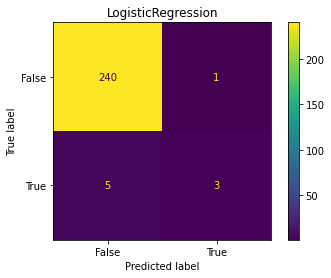

In [42]:
def plot_cm(y_test, y_pred, clf): 
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=clf.classes_)
    disp.plot()
    disp.ax_.set_title(str(clf).partition('(')[0])
    plt.show()

plot_cm(y_test, y_pred, clf)

In [28]:
f2score = fbeta_score(y_test, y_pred, beta=2)
f2score

0.9756097560975611

In [29]:
model = LogisticRegression(random_state=r_state)
f2_scorer = make_scorer(fbeta_score, beta=2)

In [30]:
scores = cross_val_score(model, X_train, y_train, scoring=f2_scorer, cv=split, n_jobs=-1)
scores.mean()

0.9625

In [31]:
models = [LogisticRegression(random_state=r_state),
          SVC(random_state=r_state),
          GaussianNB(),
          SGDClassifier(random_state=r_state),
          KNeighborsClassifier(),
          DecisionTreeClassifier(random_state=r_state),
          RandomForestClassifier(random_state=r_state),
          GradientBoostingClassifier(random_state=r_state)]
scores = PrettyTable(['Model', 'Beta 2 Score'])
for model in models:
    score = cross_val_score(model, X, y, scoring=f2_scorer, cv=split, n_jobs=-1).mean()
    scores.add_row([model, score])
print(scores.get_string(sortby="Beta 2 Score", reversesort=True))

+---------------------------------------------+--------------------+
|                    Model                    |    Beta 2 Score    |
+---------------------------------------------+--------------------+
|        SGDClassifier(random_state=42)       | 0.9386243386243386 |
| GradientBoostingClassifier(random_state=42) | 0.8638461538461538 |
|   DecisionTreeClassifier(random_state=42)   | 0.8217408906882591 |
|   RandomForestClassifier(random_state=42)   | 0.6725274725274725 |
|             SVC(random_state=42)            | 0.6164228753702439 |
|     LogisticRegression(random_state=42)     | 0.6009058320271136 |
|            KNeighborsClassifier()           | 0.3152958152958153 |
|                 GaussianNB()                | 0.1451496929663664 |
+---------------------------------------------+--------------------+


In [32]:
warnings.filterwarnings('ignore')
sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = 0.5
sample_weights[y_train == 1] = 9.1
y_pred=[]
fit_models=[]
models = (SGDClassifier(random_state=r_state, n_jobs=-1), 
          GradientBoostingClassifier(random_state=r_state),
          DecisionTreeClassifier(random_state=r_state))
search_spaces = [{'loss' : Categorical(['hinge', 'log',
                       'modified_huber', 'squared_hinge',
                       'perceptron', 'huber',
                       'epsilon_insensitive', 'squared_epsilon_insensitive']),
                  'penalty' : Categorical(['l2', 'l1', 'elasticnet']),
                  'alpha' : Real(0.0001, 1)
                 },
                {'loss' : Categorical(['deviance', 'exponential']),
                 'learning_rate' : Real(0.001, 1),
                 'n_estimators' : Integer(50, 250),
                 'criterion' : Categorical(['friedman_mse', 'squared_error']),
                 'min_samples_split' : Integer(2, 15),
                 'min_samples_leaf' : Real(0.0001, .49999),
                 'min_weight_fraction_leaf' : Real(0, .49999),
                 'max_depth' : Integer(1, 12),
                 'min_impurity_decrease' : Real(0, 2),
                 'max_features' : Categorical(['auto', 'sqrt', 'log2']),
                 'max_leaf_nodes' : Integer(2, 100)
                },
                {'criterion' : Categorical(['gini', 'entropy']),
                 'splitter' : Categorical(['best', 'random']),
                 'max_depth' : Integer(1, 100),
                 'min_samples_split' : Integer(2, 15),
                 'min_samples_leaf' : Real(0.0001, .49999),
                 'max_features' : Categorical(['auto', 'sqrt', 'log2', None]),
                 'max_leaf_nodes' : Integer(2, 250)
                    
                }]
for i in range(len(models)):
    fit_models.append(BayesSearchCV(models[i],
                                    search_spaces=search_spaces[i],
                                    random_state=r_state,
                                    scoring=f2_scorer,
                                    n_jobs=-1).fit(X_train, y_train, sample_weight = sample_weights))
    y_pred.append(fit_models[i].predict(X_test))


# 5. Conclusions
&emsp;The models selected perform well on this data set.  The SGD classified best, with an F2 score of .975, considered very good.  The SGD only misclassified one sample from the test set, and it was a false positive.  If we could detect cervical cancer with 100% recall, and 88.9% precision, it would correspond with a 0% false negative rate, and an accuracy of 99.6%.  It is also convenient that the best fitting model is also one of the quickest to fit.  It is a little harder to determine how it arrives at these decisions.  The Gradient Boost, and Decision Tree classifiers whittled down the data features to 3 important features: Dx:Cancer, Dx:CIN, and Dx:HPV.  The SGD only assigned zero weight to 4 features: STDs:pelvic inflammatory disease, STDs:genital herpes, STDs:molluscum contagiosum, and STDs:Hepatitis B.

&emsp;There are a few concerns with these data.  The first is that there are not enough samples in the dataset to confidently deploy this model.  In our estimation, assuming that the ratio of patients diagnosed with cervical cancer will not change, we would require between 50,000 and 100,000 samples to bulk up the minority class to ensure that we are accurately capturing trends in the minority data.
&emsp;Second, the data were collected in Venezuela.  This could have a variety of implications.  We don't understand the reasons that caused the patients to be evaluated, the methodology of surveying, or whether the data were accurate.
&emsp;Third, data from patients who did not want to respond to certain questions for privacy reasons.  This may have skewed our data in unpredictable ways.  We could probably run this same analysis, removing the surveyed features but keeping those samples in the data, to see how it effects our conclusions.

In [83]:
for model in fit_models:
    if model == fit_models[0]:
        print(model.best_estimator_)
        print("\033[1mZero weight\033[0m")
        for i,e in enumerate(model.best_estimator_.coef_[0]):
            if e == 0:
                print(X.columns[i])
        print("\033[1mPos weight\033[0m")
        for i,e in enumerate(model.best_estimator_.coef_[0]):
            if e > 0:
                print(X.columns[i])
        print("\033[1mNeg weight\033[0m")
        for i,e in enumerate(model.best_estimator_.coef_[0]):
            if e < 0:
                print(X.columns[i])
    if model != fit_models[0]:
        print("\n")
        print(model.best_estimator_)
        print("\033[1mPos weight\033[0m")
        for i,e in enumerate(model.best_estimator_.feature_importances_):
            if e != 0:
                print(X.columns[i])
#         print(model.best_estimator_.feature_importances_)

SGDClassifier(loss='modified_huber', n_jobs=-1, random_state=42)
Zero weight
STDs:pelvic inflammatory disease
STDs:genital herpes
STDs:molluscum contagiosum
STDs:Hepatitis B
Pos weight
Number of sexual partners
First sexual intercourse
Hormonal Contraceptives
IUD
IUD (years)
STDs
STDs:HPV
STDs: Number of diagnosis
Dx:Cancer
Dx:CIN
Dx:HPV
Schiller
Citology
Neg weight
Age
Num of pregnancies
Smokes
Smokes (years)
Smokes (packs/year)
Hormonal Contraceptives (years)
STDs (number)
STDs:condylomatosis
STDs:vaginal condylomatosis
STDs:vulvo-perineal condylomatosis
STDs:syphilis
STDs:HIV
Hinselmann
Biopsy


GradientBoostingClassifier(learning_rate=0.5636161773631237, max_depth=12,
                           max_features='sqrt', max_leaf_nodes=2,
                           min_impurity_decrease=2.0, min_samples_leaf=0.0001,
                           min_samples_split=15, n_estimators=50,
                           random_state=42)
Pos weight
Smokes (years)
IUD
Dx:Cancer
Dx:CIN
Dx:HPV


Decision

In [65]:
print(X.columns[[5,9,24,25,26]])
print(X.columns[[24,25]])

Index(['Smokes (years)', 'IUD', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV'], dtype='object')
Index(['Dx:Cancer', 'Dx:CIN'], dtype='object')


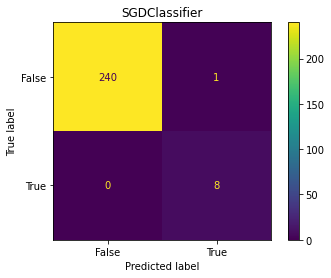

SGDClassifier(loss='modified_huber', n_jobs=-1, random_state=42) F2 Score =  0.9756097560975611


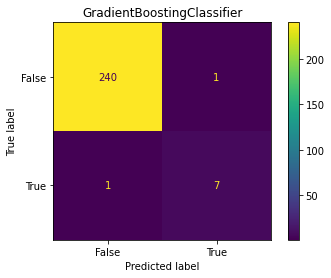

GradientBoostingClassifier(learning_rate=0.5636161773631237, max_depth=12,
                           max_features='sqrt', max_leaf_nodes=2,
                           min_impurity_decrease=2.0, min_samples_leaf=0.0001,
                           min_samples_split=15, n_estimators=50,
                           random_state=42) F2 Score =  0.875


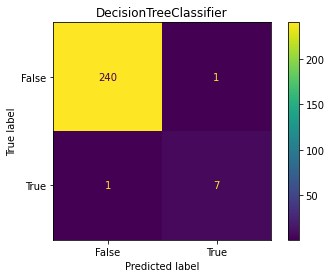

DecisionTreeClassifier(criterion='entropy', max_depth=90, max_leaf_nodes=213,
                       min_samples_leaf=0.0001, min_samples_split=15,
                       random_state=42, splitter='random') F2 Score =  0.875


In [45]:
for i in range(len(fit_models)):
    y_pred = fit_models[i].predict(X_test)
    f2score = fbeta_score(y_test, y_pred, beta=2)
    plot_cm(y_test, y_pred, fit_models[i].best_estimator_)
    print(fit_models[i].best_estimator_, "F2 Score = ", f2score)

In [35]:
scores = PrettyTable(['Model', 'Beta 2 CV Score'])

for i in range(len(fit_models)):
    score = cross_val_score(fit_models[i], X, y, scoring=f2_scorer, cv=split, n_jobs=-1).mean()
    scores.add_row([fit_models[i].estimator, score])

print(scores.get_string(sortby="Beta 2 CV Score", reversesort=True))

+---------------------------------------------+--------------------+
|                    Model                    |  Beta 2 CV Score   |
+---------------------------------------------+--------------------+
|  SGDClassifier(n_jobs=-1, random_state=42)  | 0.9060428849902534 |
| GradientBoostingClassifier(random_state=42) | 0.8981481481481481 |
|   DecisionTreeClassifier(random_state=42)   | 0.856519075466444  |
+---------------------------------------------+--------------------+


In [36]:
def pr_plot(model):
    display=PrecisionRecallDisplay.from_estimator(model.best_estimator_, X_test, y_test, name=model.estimator)
    _ = display.ax_.set_title("{} Precision-Recall Curve".format(str(model.estimator).partition('(')[0]))

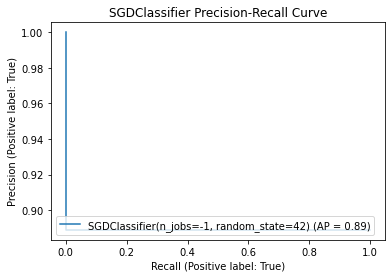

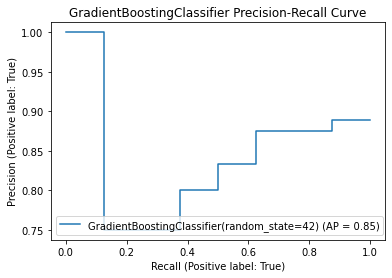

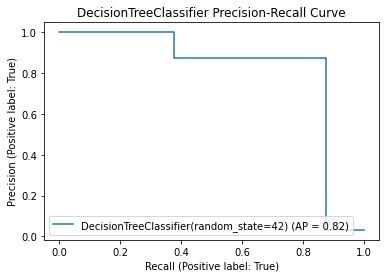

In [37]:
for i in range(len(fit_models)):
    pr_plot(fit_models[i])

In [38]:
# Loss function: Precision-recall curve and AOC, because positive class is more important
# G-mean metric?
# If the positive class is more important, then variations of the F-Measure can be used that optimize the precision and recall
# F2-Measure

# 6. References

Cervical Cancer Statistics. (2022, January 12). American Cancer Society. Retrieved August 9, 2022, from https://www.cancer.org/cancer/cervical-cancer/about/key-statistics.html

Cervical Cancer Survival Rates | Cancer 5 Year Survival Rates. (2022, March 1). American Cancer Society. Retrieved August 9, 2022, from https://www.cancer.org/cancer/cervical-cancer/detection-diagnosis-staging/survival.html

Fernandes, K. (2017, March 3). UCI Machine Learning Repository: Cervical cancer (Risk Factors) Data Set. UC Irvine Machine Learning Repository. Retrieved August 9, 2022, from http://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29

Fernandes, K., Cardoso, J. S., & Fernandes, J. (2017). Transfer Learning with Partial Observability Applied to Cervical Cancer Screening. Pattern Recognition and Image Analysis, 243–250. https://doi.org/10.1007/978-3-319-58838-4_27

Srivastava, T. (2020, August 5). 11 Important Model Evaluation Metrics for Machine Learning Everyone should know. Analytics Vidhya. Retrieved August 10, 2022, from https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

